# Geographic Data Science with Python - Report 5

---

## Section 1: Summary of Readings

### Chapter 6: Global Spatial Autocorrelation

#### What is Spatial Autocorrelation?
- Measures how values at one location relate to those nearby.
- Opposite of spatial randomness, where location tells us nothing about values.
- Two types:
  - **Positive**: Similar values cluster (e.g., wealthy areas near each other).
  - **Negative**: Dissimilar values are neighbors (e.g., competing stores avoid each other).
- Can be:
  - **Global**: Measures overall tendency.
  - **Local**: Measures location-specific patterns (see Chapter 7).

### Key Concepts & Tools

#### 1. Spatial Lag
- A spatial lag is the weighted average of neighboring values.
- For location *i*, spatial lag = sum of (weight between *i* and *j*) × (value at *j*).
- In matrix notation: SpatialLag = W × Y
- Captures how values are influenced by their spatial context.

#### 2. Binary Case: Join Counts
- Converts the variable into binary form (e.g., Leave vs Remain).
- Counts how often similar neighbors appear:
  - GG: both neighbors are in group G
  - YY: both are in group Y
  - GY: one in each
- Compare observed vs expected under randomness.
- Excess similar joins → evidence of positive spatial autocorrelation.

#### 3. Continuous Case

##### Moran Plot
- Plot of standardized values vs. their spatial lags.
- The slope of the line indicates the level of spatial autocorrelation.
  - Steeper positive slope = stronger positive autocorrelation.

##### Moran’s I
- Summary index of spatial autocorrelation for continuous data.
- Formula involves:
  - Number of observations (n)
  - Spatial weights
  - Standardized values (z-scores)
- Typical values:
  - Close to +1: strong positive clustering
  - Around 0: spatial randomness
  - Negative: dispersion
- Significance tested via random permutations.

#### 4. Other Global Indices
- **Geary’s C**:
  - Based on squared differences between neighbors.
  - Focuses more on local variability than Moran’s I.
  - Value close to 1 indicates randomness.
- **Getis-Ord G**:
  - Measures clustering of high or low values (hot spots and cold spots).
  - Cannot detect negative spatial autocorrelation.
  - Sensitive to distance rather than neighborhood structure.

#### Case Study: Brexit Vote
- Variable: Percent of Leave votes by local authority in the UK.
- Strong global spatial autocorrelation detected:
  - Join counts: revealed clustering.
  - Moran’s I ≈ 0.645 (high clustering).
  - Geary’s C ≈ 0.41 (low local variability).
  - Getis-Ord G ≈ 0.434 (significant hot spots).
- Conclusion: spatial patterns were unlikely to occur by chance.

### Conclusion
- Global spatial autocorrelation helps detect whether values cluster across space.
- Important for checking assumptions before spatial modeling.
- Prepares the way for **local** analysis, where we examine *where* clustering occurs.


### Chapter 7: Local Spatial Autocorrelation

#### What is Local Spatial Autocorrelation?
- Measures spatial clustering at individual locations.
- Answers: *Where* do clusters or spatial outliers occur?
- Complements global autocorrelation (Chapter 6) by zooming into location-specific patterns.

### Key Methods

#### 1. Local Moran's I (LISA)
- Calculates a value for each location based on how similar it is to its neighbors.
- Identifies:
  - **High–High (HH)**: high values surrounded by high values
  - **Low–Low (LL)**: low values surrounded by low values
  - **High–Low (HL)**: high value surrounded by low values (spatial outlier)
  - **Low–High (LH)**: low value surrounded by high values (spatial outlier)
- Provides:
  - **Significance maps**: where clustering is statistically significant.
  - **Cluster maps**: what kind of clustering occurs where.

#### 2. Median Local Moran
- A more robust version of Local Moran.
- Uses the median of neighbors instead of the mean.
- Reduces sensitivity to extreme outliers.

#### 3. Local Geary's C
- Focuses on local differences between neighbors.
- Detects areas with unusually large or small variance relative to neighbors.
- Complements Moran by offering a different perspective on local structure.

#### 4. Local Getis-Ord G
- Identifies clusters of high or low values:
  - **Hot spots**: high values near high values
  - **Cold spots**: low values near low values
- Does not detect outliers (e.g., high surrounded by low).

#### 5. Differential Local Moran
- Applies LISA to the *change* in values over time (e.g., from one election to the next).
- Highlights where change patterns match or deviate from neighbors.
- Useful for dynamic spatial analysis.

### Case Study Highlights
- Applied to Brexit vote data (again).
- Median Moran slightly reduces detection of outliers, confirms core clusters.
- Changing significance thresholds or number of permutations affects cluster detection.
- Differential Moran shows consistent changes in some regions, divergence in others.

### Summary
- Local spatial autocorrelation methods show *where* clustering or outliers exist.
- Use:
  - **Local Moran**: general-purpose detection of clusters/outliers
  - **Median Moran**: robust to noise
  - **Geary's C**: focus on local variability
  - **Getis-Ord G**: best for hot/cold spot detection
  - **Differential Moran**: for time-based comparisons
- These tools are essential for spatial diagnostics, policy targeting, and deeper spatial analysis.


## Section 2: Working With Python
### An empirical illustration: the EU Referendum

In [58]:
import matplotlib.pyplot as plt  # Graphics
from matplotlib import colors
import seaborn  # Graphics
import geopandas  # Spatial data manipulation
import pandas  # Tabular data manipulation
import rioxarray  # Surface data manipulation
import xarray  # Surface data manipulation
from pysal.explore import esda  # Exploratory Spatial analytics
from pysal.lib import weights  # Spatial weights
import contextily  # Background tiles

In [59]:
data_root = "C:/Users/riley/Desktop/book/"
ref = pandas.read_csv(
    data_root + "/data/brexit/brexit_vote.csv", index_col="Area_Code"
)

In [60]:
lads = geopandas.read_file(
    data_root + "/data/brexit/local_authority_districts.geojson"
).set_index("lad16cd")

In [61]:
db = (
    geopandas.GeoDataFrame(
        lads.join(ref[["Pct_Leave"]]), crs=lads.crs
    )
    .to_crs(epsg=3857)[
        ["objectid", "lad16nm", "Pct_Leave", "geometry"]
    ]
    .dropna()
)

db.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Index: 380 entries, E06000001 to W06000023
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   objectid   380 non-null    int32   
 1   lad16nm    380 non-null    object  
 2   Pct_Leave  380 non-null    float64 
 3   geometry   380 non-null    geometry
dtypes: float64(1), geometry(1), int32(1), object(1)
memory usage: 13.4+ KB


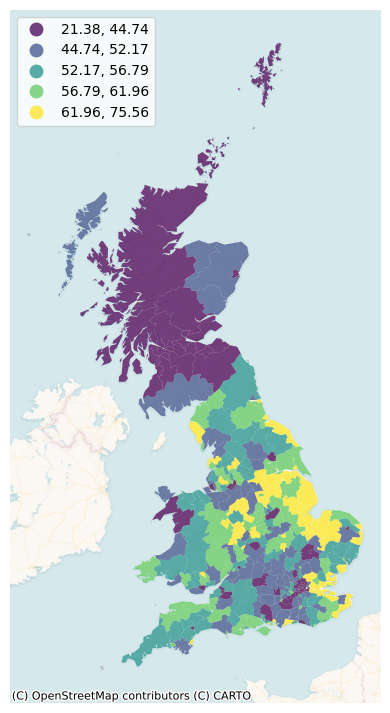

In [62]:
# Set up figure and a single axis
f, ax = plt.subplots(1, figsize=(9, 9))
# Build choropleth
db.plot(
    column="Pct_Leave",
    cmap="viridis",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.0,
    alpha=0.75,
    legend=True,
    legend_kwds=dict(loc=2),
    ax=ax,
)
# Add basemap
contextily.add_basemap(
    ax,
    crs=db.crs,
    source=contextily.providers.CartoDB.VoyagerNoLabels,
)
# Remove axes
ax.set_axis_off();

In [63]:
# Generate W from the GeoDataFrame
w = weights.distance.KNN.from_dataframe(db, k=8)
# Row-standardization
w.transform = "R"

### Motivation local spatial autocorrelation

In [64]:
db["w_Pct_Leave"] = weights.lag_spatial(w, db['Pct_Leave'])

In [65]:
db["Pct_Leave_std"] = db["Pct_Leave"] - db["Pct_Leave"].mean()
db["w_Pct_Leave_std"] = weights.lag_spatial(w, db['Pct_Leave_std'])

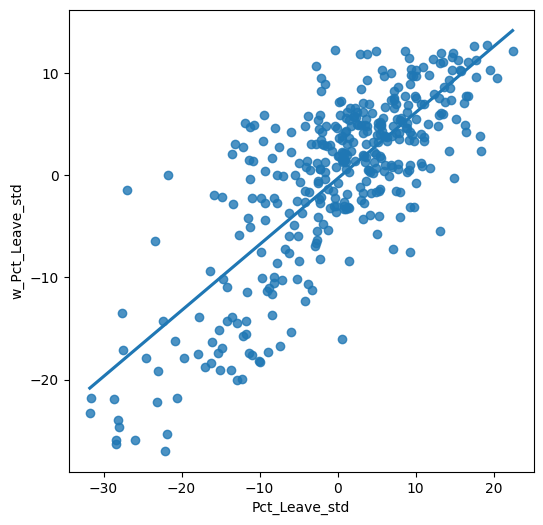

In [66]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
)
plt.show()

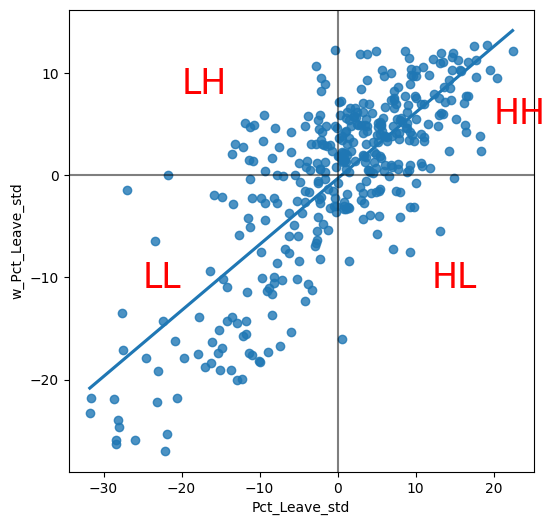

In [67]:
# Set up the figure and axis
f, ax = plt.subplots(1, figsize=(6, 6))
# Plot values
seaborn.regplot(
    x="Pct_Leave_std", y="w_Pct_Leave_std", data=db, ci=None
)
# Add vertical and horizontal lines
plt.axvline(0, c="k", alpha=0.5)
plt.axhline(0, c="k", alpha=0.5)
# Add text labels for each quadrant
plt.text(20, 5, "HH", fontsize=25, c="r")
plt.text(12, -11, "HL", fontsize=25, c="r")
plt.text(-20, 8.0, "LH", fontsize=25, c="r")
plt.text(-25, -11.0, "LL", fontsize=25, c="r")
# Display
plt.show()

### Local Moran’s

In [68]:
lisa = esda.moran.Moran_Local(db["Pct_Leave"], w)

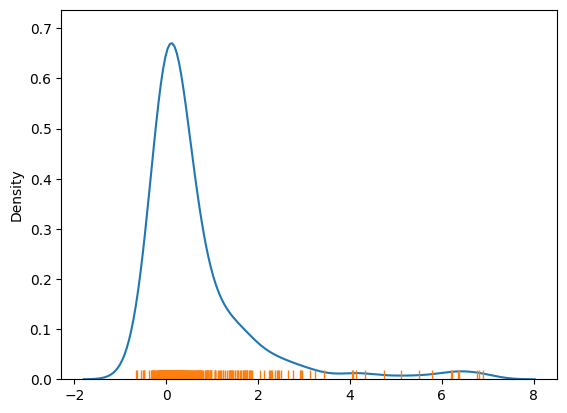

In [69]:
# Draw KDE line
ax = seaborn.kdeplot(lisa.Is)
# Add one small bar (rug) for each observation
# along horizontal axis
seaborn.rugplot(lisa.Is, ax=ax);

In [70]:
from splot import esda as esdaplot

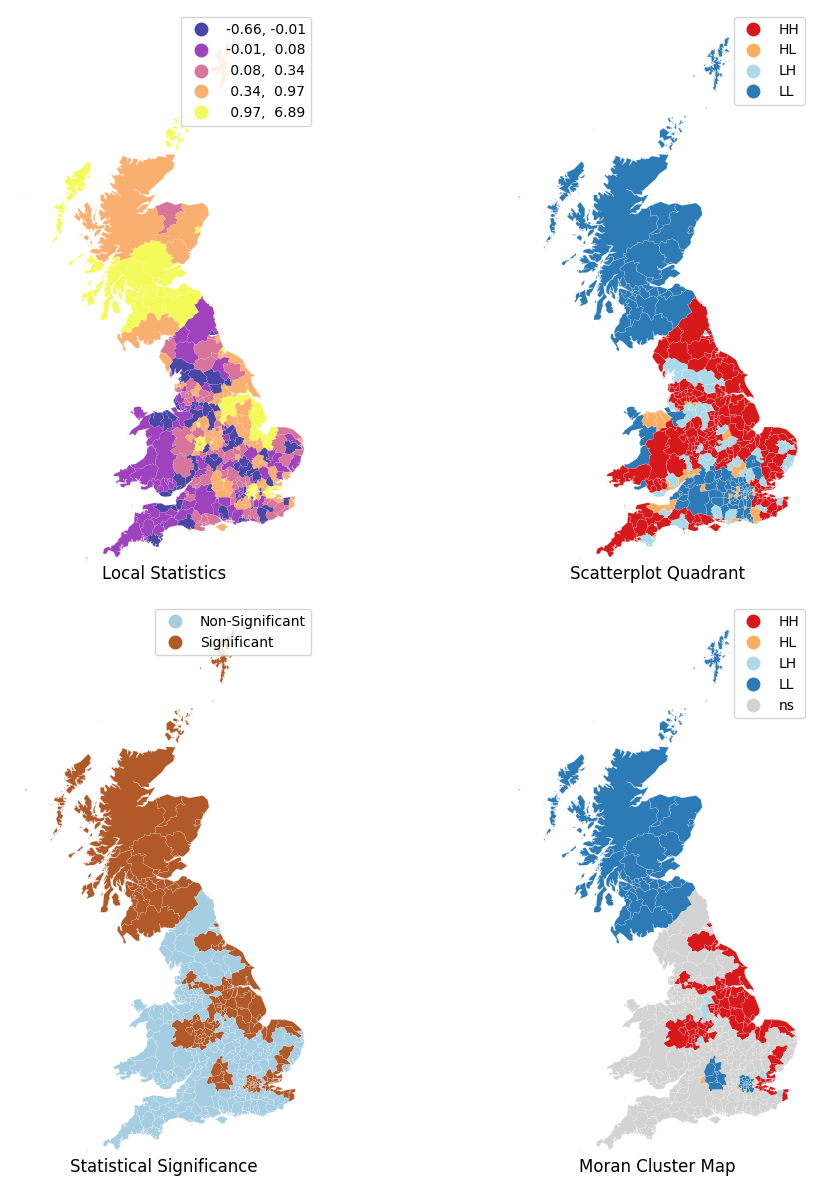

In [71]:
# Set up figure and axes
f, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Subplot 1 #
# Choropleth of local statistics
# Grab first axis in the figure
ax = axs[0]
# Assign new column with local statistics on-the-fly
db.assign(
    Is=lisa.Is
    # Plot choropleth of local statistics
).plot(
    column="Is",
    cmap="plasma",
    scheme="quantiles",
    k=5,
    edgecolor="white",
    linewidth=0.1,
    alpha=0.75,
    legend=True,
    ax=ax,
)

# Subplot 2 #
# Quadrant categories
# Grab second axis of local statistics
ax = axs[1]
# Plot Quadrant colors (note to ensure all polygons are assigned a
# quadrant, we "trick" the function by setting significance level to
# 1 so all observations are treated as "significant" and thus assigned
# a quadrant color
esdaplot.lisa_cluster(lisa, db, p=1, ax=ax)

# Subplot 3 #
# Significance map
# Grab third axis of local statistics
ax = axs[2]
#
# Find out significant observations
labels = pandas.Series(
    1 * (lisa.p_sim < 0.05),  # Assign 1 if significant, 0 otherwise
    index=db.index  # Use the index in the original data
    # Recode 1 to "Significant and 0 to "Non-significant"
).map({1: "Significant", 0: "Non-Significant"})
# Assign labels to `db` on the fly
db.assign(
    cl=labels
    # Plot choropleth of (non-)significant areas
).plot(
    column="cl",
    categorical=True,
    k=2,
    cmap="Paired",
    linewidth=0.1,
    edgecolor="white",
    legend=True,
    ax=ax,
)


# Subplot 4 #
# Cluster map
# Grab second axis of local statistics
ax = axs[3]
# Plot Quadrant colors In this case, we use a 5% significance
# level to select polygons as part of statistically significant
# clusters
esdaplot.lisa_cluster(lisa, db, p=0.05, ax=ax)

# Figure styling #
# Set title to each subplot
for i, ax in enumerate(axs.flatten()):
    ax.set_axis_off()
    ax.set_title(
        [
            "Local Statistics",
            "Scatterplot Quadrant",
            "Statistical Significance",
            "Moran Cluster Map",
        ][i],
        y=0,
    )
# Tight layout to minimize in-between white space
f.tight_layout()

# Display the figure
plt.show()

In [72]:
lisa.q[:10]

array([1, 1, 1, 1, 1, 1, 4, 1, 4, 1])

In [73]:
counts = pandas.value_counts(lisa.q)
counts

C:\Users\riley\AppData\Local\Temp\ipykernel_14856\3518240389.py:1: FutureWarning: pandas.value_counts is deprecated and will be removed in a future version. Use pd.Series(obj).value_counts() instead.
  counts = pandas.value_counts(lisa.q)


1    183
3    113
2     50
4     34
Name: count, dtype: int64

In [74]:
(lisa.p_sim < 0.05).sum() * 100 / len(lisa.p_sim)

np.float64(41.31578947368421)

In [75]:
# Assign pseudo P-values to `db`
db["p-sim"] = lisa.p_sim
# `1` if significant (at 5% confidence level), `0` otherwise
sig = 1 * (lisa.p_sim < 0.05)
# Assign significance flag to `db`
db["sig"] = sig
# Print top of the table to inspect
db[["sig", "p-sim"]].head()

,sig,p-sim
lad16cd,,
E06000001,1,0.006
E06000002,1,0.005
E06000003,1,0.006
E06000004,1,0.006
E06000010,1,0.008


In [76]:
# Print bottom of the table to inspect
db[["sig", "p-sim"]].tail()

,sig,p-sim
lad16cd,,
W06000018,0,0.477
W06000019,0,0.467
W06000021,0,0.462
W06000022,0,0.383
W06000023,0,0.277


In [77]:
# Pick as part of a quadrant only significant polygons,
# assign `0` otherwise (Non-significant polygons)
spots = lisa.q * sig
# Mapping from value to name (as a dict)
spots_labels = {
    0: "Non-Significant",
    1: "HH",
    2: "LH",
    3: "LL",
    4: "HL",
}
# Create column in `db` with labels for each polygon
db["labels"] = pandas.Series(
    # First initialise a Series using values and `db` index
    spots,
    index=db.index
    # Then map each value to corresponding label based
    # on the `spots_labels` mapping
).map(spots_labels)
# Print top for inspection
db["labels"].head()

lad16cd
E06000001    HH
E06000002    HH
E06000003    HH
E06000004    HH
E06000010    HH
Name: labels, dtype: object

In [78]:
db["labels"].value_counts()

labels
Non-Significant    223
HH                  77
LL                  69
LH                   7
HL                   4
Name: count, dtype: int64

### Getis and Ord’s local statistics

In [79]:
# Gi
go_i = esda.getisord.G_Local(db["Pct_Leave"], w)
# Gi*
go_i_star = esda.getisord.G_Local(db["Pct_Leave"], w, star=True)

c:\Users\riley\repos\GIS-independent-study\.venv\lib\site-packages\esda\getisord.py:615: UserWarning: Gi* requested, but (a) weights are already row-standardized, (b) no weights are on the diagonal, and (c) no default value supplied to star. Assuming that the self-weight is equivalent to the maximum weight in the row. To use a different default (like, .5), set `star=.5`, or use libpysal.weights.fill_diagonal() to set the diagonal values of your weights matrix and use `star=None` in Gi_Local.
  warnings.warn(


In [80]:
def g_map(g, db, ax):
    """
    Create a cluster map
    ...

    Arguments
    ---------
    g      : G_Local
             Object from the computation of the G statistic
    db     : GeoDataFrame
             Table aligned with values in `g` and containing
             the geometries to plot
    ax     : AxesSubplot
             `matplotlib` axis to draw the map on

    Returns
    -------
    ax     : AxesSubplot
             Axis with the map drawn
    """
    ec = "0.8"

    # Break observations into significant or not
    sig = g.p_sim < 0.05

    # Plot non-significant clusters
    ns = db.loc[sig == False, "geometry"]
    ns.plot(ax=ax, color="lightgrey", edgecolor=ec, linewidth=0.1)
    # Plot HH clusters
    hh = db.loc[(g.Zs > 0) & (sig == True), "geometry"]
    hh.plot(ax=ax, color="red", edgecolor=ec, linewidth=0.1)
    # Plot LL clusters
    ll = db.loc[(g.Zs < 0) & (sig == True), "geometry"]
    ll.plot(ax=ax, color="blue", edgecolor=ec, linewidth=0.1)
    # Style and draw
    contextily.add_basemap(
        ax,
        crs=db.crs,
        source=contextily.providers.Esri.WorldTerrain,
    )
    # Flag to add a star to the title if it's G_i*
    st = ""
    if g.star:
        st = "*"
    # Add title
    ax.set_title(f"G{st} statistic for Pct of Leave votes", size=15)
    # Remove axis for aesthetics
    ax.set_axis_off()
    return ax

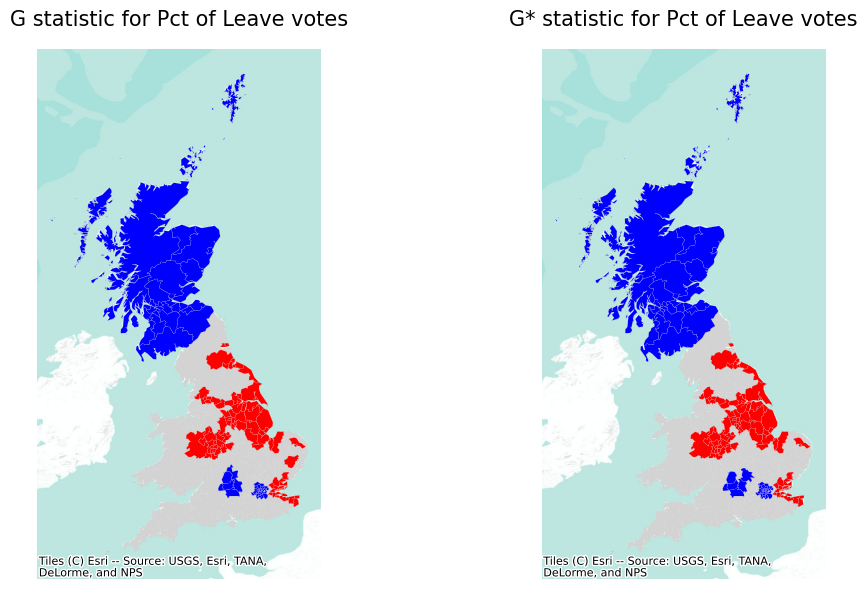

In [81]:
# Set up figure and axes
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Loop over the two statistics
for g, ax in zip([go_i, go_i_star], axs.flatten()):
    # Generate the statistic's map
    ax = g_map(g, db, ax)
# Tight layout to minimise blank spaces
f.tight_layout()
# Render
plt.show()

### Bonus: local statistics on surfaces

In [82]:
# Open GeoTIFF file and read into `xarray.DataArray`
pop = rioxarray.open_rasterio(data_root + "/data/ghsl/ghsl_sao_paulo.tif")

In [83]:
w_surface_sp = weights.Queen.from_xarray(pop)

In [84]:
w_surface_sp.sparse.dtype

dtype('int8')

In [85]:
type(w_surface_sp)

libpysal.weights.weights.WSP

In [86]:
w_surface_all = weights.WSP2W(  # 3.Convert `WSP` object to `W`
    weights.WSP(  # 2a.Build `WSP` from the float sparse matrix
        w_surface_sp.sparse.astype(
            float
        ),  # 1.Convert sparse matrix to floats
        id_order=w_surface_sp.index.tolist() # 2b. Ensure `W` is indexed
    )
)
w_surface_all.index = w_surface_sp.index  # 4.Assign index to new `W`

In [87]:
# Convert `DataArray` to a `pandas.Series`
pop_values = pop.to_series()
# Subset to keep only values that aren't missing
pop_values = pop_values[pop_values != pop.rio.nodata]

In [88]:
pop.rio.nodata

np.float32(-200.0)

In [89]:
w_surface = weights.w_subset(w_surface_all, pop_values.index)
w_surface.index = pop_values.index

In [90]:
# NOTE: this may take a bit longer to run depending on hardware
pop_lisa = esda.moran.Moran_Local(
    pop_values.astype(float), w_surface, n_jobs=-1
)

In [91]:
from libpysal.weights import raster

In [92]:
sig_pop = pandas.Series(
    pop_lisa.q
    * (
        pop_lisa.p_sim < 0.01
    ),  # Quadrant of significant at 1% (0 otherwise)
    index=pop_values.index,  # Index from the Series and aligned with `w_surface`
)

In [93]:
# Build `DataArray` from a set of values and weights
lisa_da = raster.w2da(
    sig_pop,  # Values
    w_surface,  # Spatial weights
    attrs={
        "nodatavals": [pop.rio.nodata]
    }  # Value for missing data
    # Add CRS information in a compliant manner
).rio.write_crs(pop.rio.crs)

In [94]:
lisa_da.to_series().unique()

array([-200,    0,    3,    1,    2,    4])

In [95]:
from matplotlib.colors import ListedColormap

In [96]:
# LISA colors
lc = {
    "ns": "lightgrey",  # Values of 0
    "HH": "#d7191c",  # Values of 1
    "LH": "#abd9e9",  # Values of 2
    "LL": "#2c7bb6",  # Values of 3
    "HL": "#fdae61",  # Values of 4
}

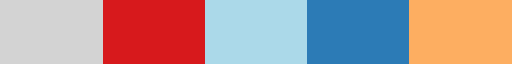

In [97]:
lisa_cmap = ListedColormap(
    [lc["ns"], lc["HH"], lc["LH"], lc["LL"], lc["HL"]]
)
lisa_cmap

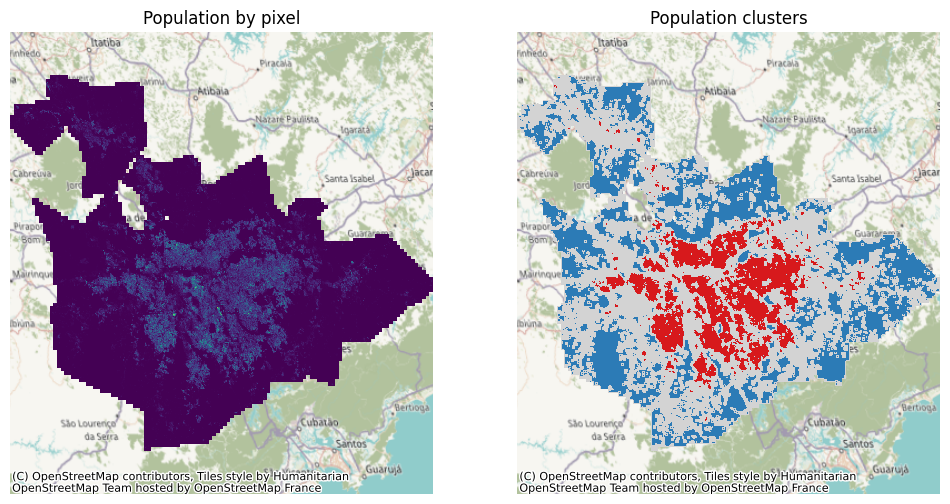

In [98]:
# Set up figure and axis
f, axs = plt.subplots(1, 2, figsize=(12, 6))
# Subplot 1 #
# Select pixels that do not have the `nodata` value
# (ie. they are not missing data)
pop.where(
    pop
    != pop.rio.nodata
    # Plot surface with a horizontal colorbar
).plot(
    ax=axs[0],
    add_colorbar=False,  # , cbar_kwargs={"orientation": "horizontal"}
)
# Subplot 2 #
# Select pixels with no missing data and rescale to [0, 1] by
# dividing by 4 (maximum value in `lisa_da`)
(
    lisa_da.where(lisa_da != -200)
    / 4
    # Plot surface without a colorbar
).plot(cmap=lisa_cmap, ax=axs[1], add_colorbar=False)
# Aesthetics #
# Subplot titles
titles = ["Population by pixel", "Population clusters"]
# Apply the following to each of the two subplots
for i in range(2):
    # Keep proportion of axes
    axs[i].axis("equal")
    # Remove axis
    axs[i].set_axis_off()
    # Add title
    axs[i].set_title(titles[i])
    # Add basemap
    contextily.add_basemap(axs[i], crs=lisa_da.rio.crs)

## Section 3 - Assignment

Python Script: Use OSMnx to model 15-minute walking buffers around clinics. Map underserved areas.

In [99]:
import osmnx as ox
import networkx as nx
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [100]:
place = "Missoula, Montana, USA"
G = ox.graph_from_place(place, network_type='walk')
G_proj = ox.project_graph(G)
crs = G_proj.graph['crs']

In [101]:
addresses = [
    "2901 Brooks St, Missoula, MT 59801",
    "2307 Brooks St, Missoula, MT 59801",
    "3075 N Reserve St, Missoula, MT 59808",
    "401 Railroad St W, Missoula, MT 59802",
    "2230 N Reserve St, Missoula, MT 59808",
    "2827 Fort Missoula Rd, Missoula, MT 59804",
    "500 W Broadway St, Missoula, MT 59802",
    "3031 S Russell St, Missoula, MT 59801"
]

clinic_points = []
for addr in addresses:
    lat, lon = ox.geocode(addr)
    clinic_points.append(Point(lon, lat))

clinics = gpd.GeoDataFrame(geometry=clinic_points, crs="EPSG:4326")
clinics = clinics.to_crs(crs)

In [102]:
isochrones = []
for pt in clinics.geometry:
    node = ox.nearest_nodes(G_proj, X=pt.x, Y=pt.y)
    subgraph = nx.ego_graph(G_proj, node, radius=1200, distance='length')
    nodes = [Point(data['x'], data['y']) for _, data in subgraph.nodes(data=True)]
    poly = gpd.GeoSeries(nodes).union_all().convex_hull
    isochrones.append(poly)

service_union = gpd.GeoSeries(isochrones).union_all()

In [103]:

boundary = ox.geocode_to_gdf(place).to_crs(crs)
underserved = boundary.geometry.iloc[0].difference(service_union)

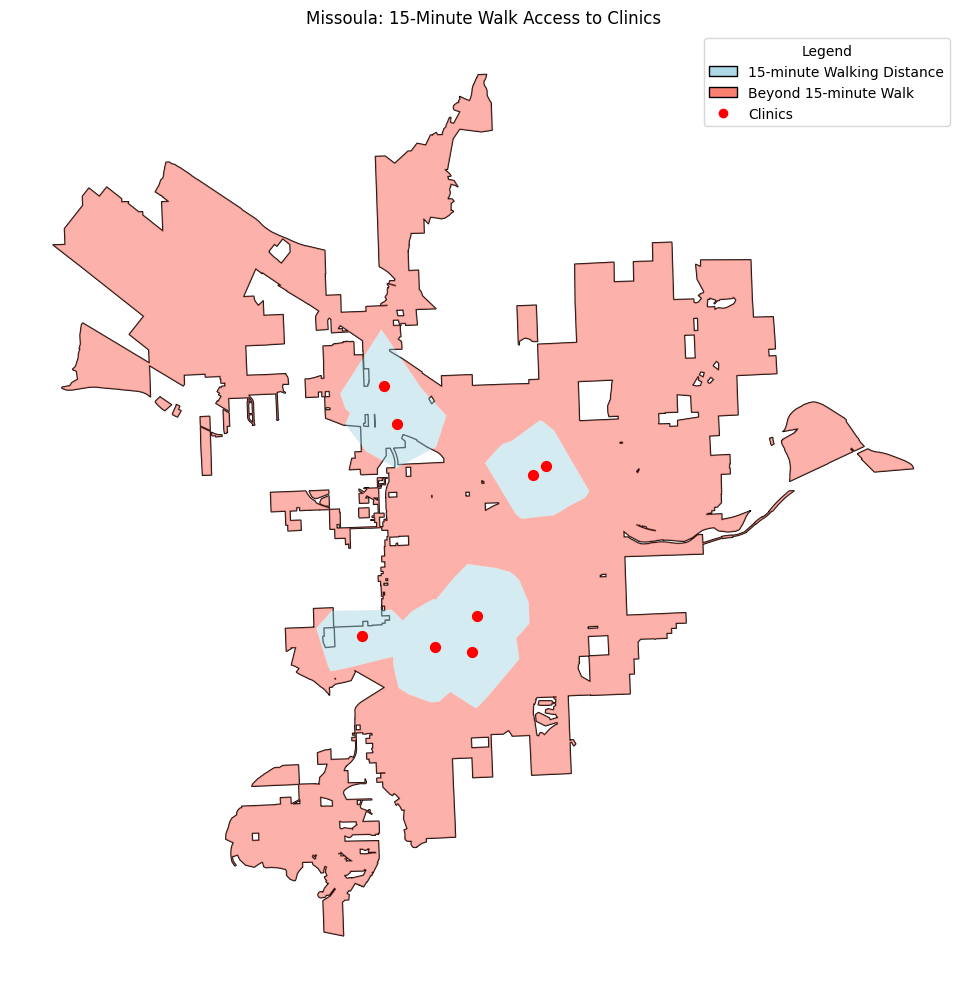

In [104]:
fig, ax = plt.subplots(figsize=(10,10))
boundary.plot(ax=ax, facecolor='none', edgecolor='black')
gpd.GeoSeries(service_union).plot(ax=ax, color='lightblue', alpha=0.5, label='15-min walk zones')
gpd.GeoSeries(underserved).plot(ax=ax, color='salmon', alpha=0.6, label='Underserved areas')
clinics.plot(ax=ax, color='red', markersize=50, label='Clinics')
legend_elements = [
    Patch(facecolor='lightblue', edgecolor='black', label='15-minute Walking Distance'),
    Patch(facecolor='salmon', edgecolor='black', label='Beyond 15-minute Walk'),
    Line2D([0], [0], marker='o', color='w', label='Clinics',
           markerfacecolor='red', markersize=8)
]

ax.legend(handles=legend_elements, title="Legend", loc='upper right')
ax.set_title("Missoula: 15-Minute Walk Access to Clinics")
ax.axis('off')
plt.tight_layout()
plt.show()